# 08a: Count Lock-In Depth Analysis

**Goal**: Determine at what depth each count domino becomes "locked in" (capture probability approaches 0 or 1).

**Key Question**: When does each count domino become "locked in" (capture probability -> 0 or 1)?

**Hypothesis**: If counts lock in early, the oracle is mostly confirming foregone conclusions.

**Method**: Track P(team0 captures count_i | depth) across the game tree.

**Output**: Per-count "lock-in depth" distribution and curves.

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict

from forge.analysis.utils import loading, features, viz, navigation
from forge.oracle import schema, tables

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Data Loading

Load multiple shards to get statistical power across different deals.

In [2]:
# Find available shard files
shard_files = loading.find_shard_files(DATA_DIR)
print(f"Total shard files available: {len(shard_files)}")

# Use a small subset for analysis (memory-constrained)
N_SHARDS = 3
print(f"Using {N_SHARDS} shards for analysis")

Total shard files available: 1314
Using 3 shards for analysis


## 2. Track Capture Probability by Depth

For each state, we track:
- Current depth (dominoes remaining)
- For each count domino still in play: P(team0 captures it) along the PV

We define "locked in" as P < 0.05 or P > 0.95.

In [3]:
# Track capture outcomes by depth for each count domino
# Structure: {domino_id: {depth: [team0_capture_count, total_count]}}
capture_by_depth = {d: defaultdict(lambda: [0, 0]) for d in features.COUNT_DOMINO_IDS}

# Also track per-seed variance to understand variability
per_seed_outcomes = []  # List of {seed, decl_id, domino_id, final_team}

for shard_file in tqdm(shard_files[:N_SHARDS], desc="Processing shards"):
    df, seed, decl_id = schema.load_file(shard_file)
    
    # Build state lookup for this shard
    state_to_idx, V, Q = navigation.build_state_lookup_fast(df)
    states = df['state'].values
    
    # Get hands for this seed
    hands = schema.deal_from_seed(seed)
    
    # Build domino -> (player, local_idx) lookup
    domino_to_location = {}
    for p in range(4):
        for local_idx, domino_id in enumerate(hands[p]):
            domino_to_location[domino_id] = (p, local_idx)
    
    # Sample states (stratified by depth for better coverage)
    depths = features.depth(states)
    unique_depths = np.unique(depths)
    
    sampled_indices = []
    SAMPLES_PER_DEPTH = 50  # Reduced from 100 for memory efficiency
    for d in unique_depths:
        depth_mask = depths == d
        depth_indices = np.where(depth_mask)[0]
        n_sample = min(SAMPLES_PER_DEPTH, len(depth_indices))
        sampled_indices.extend(np.random.choice(depth_indices, n_sample, replace=False))
    
    # Track captures for sampled states
    for idx in sampled_indices:
        state = states[idx]
        d = depths[idx]
        
        # Get which counts are still in play
        remaining, _, _, _, _, _ = navigation.unpack_state_single(state)
        
        counts_in_play = []
        for domino_id in features.COUNT_DOMINO_IDS:
            p, local_idx = domino_to_location[domino_id]
            if (remaining[p] >> local_idx) & 1:
                counts_in_play.append(domino_id)
        
        if not counts_in_play:
            continue
        
        # Track captures along PV
        captures = navigation.track_count_captures(
            state, seed, decl_id, state_to_idx, V, Q
        )
        
        for domino_id in counts_in_play:
            if domino_id in captures:
                team = captures[domino_id]
                capture_by_depth[domino_id][d][0] += (1 if team == 0 else 0)
                capture_by_depth[domino_id][d][1] += 1
                
                per_seed_outcomes.append({
                    'seed': seed,
                    'decl_id': decl_id,
                    'domino_id': domino_id,
                    'depth': d,
                    'team0_captures': team == 0,
                })
    
    # Clear memory
    del df, state_to_idx, V, Q, states

print(f"Collected {len(per_seed_outcomes):,} capture observations")

Processing shards:   0%|          | 0/3 [00:00<?, ?it/s]

Collected 8,771 capture observations


## 3. Compute Capture Probabilities by Depth

In [4]:
# Convert to probability curves
prob_curves = {}  # {domino_id: {depth: (p_team0, n_samples)}}

for domino_id in features.COUNT_DOMINO_IDS:
    prob_curves[domino_id] = {}
    for depth, (team0_count, total) in capture_by_depth[domino_id].items():
        if total > 0:
            prob_curves[domino_id][depth] = (team0_count / total, total)

# Display sample sizes
for domino_id in features.COUNT_DOMINO_IDS:
    pips = schema.domino_pips(domino_id)
    points = tables.DOMINO_COUNT_POINTS[domino_id]
    total_samples = sum(n for _, n in prob_curves[domino_id].values())
    print(f"{pips[0]}-{pips[1]} ({points}pts): {total_samples:,} samples")

3-2 (5pts): 1,793 samples
4-1 (5pts): 1,766 samples
5-0 (5pts): 1,740 samples
5-5 (10pts): 1,904 samples
6-4 (10pts): 1,568 samples


## 4. Plot Lock-In Curves

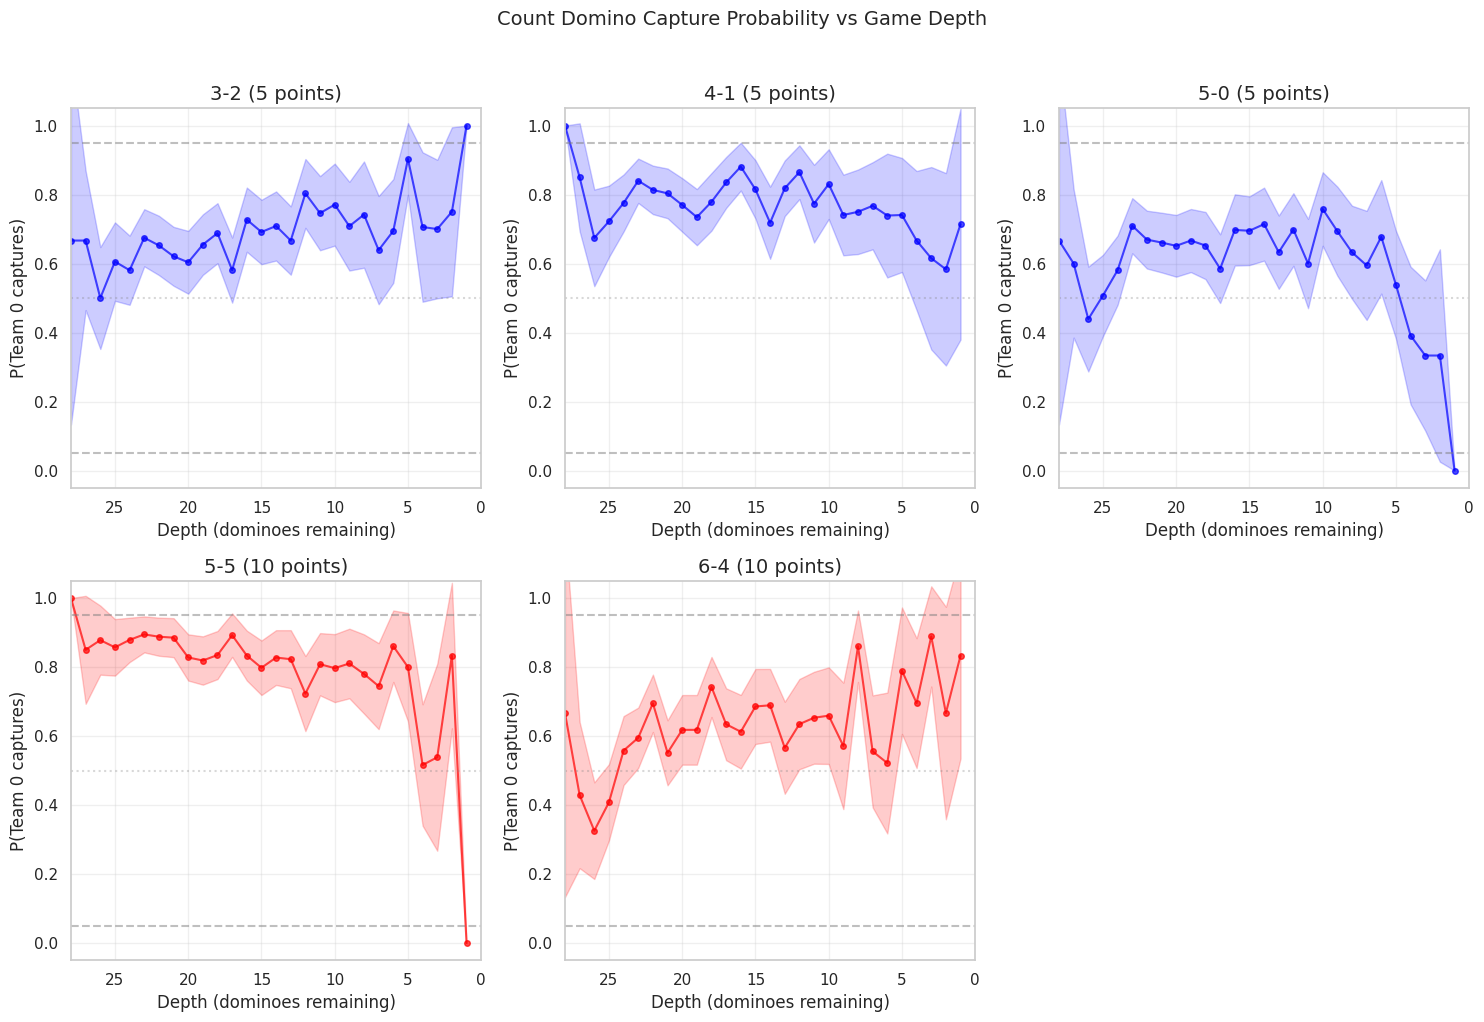

In [5]:
# Create subplots for each count domino
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, domino_id in enumerate(sorted(features.COUNT_DOMINO_IDS)):
    ax = axes[i]
    pips = schema.domino_pips(domino_id)
    points = tables.DOMINO_COUNT_POINTS[domino_id]
    
    # Color by point value
    color = 'red' if points == 10 else 'blue'
    
    if domino_id not in prob_curves or not prob_curves[domino_id]:
        ax.set_title(f'{pips[0]}-{pips[1]} ({points} points) - No data')
        continue
    
    # Extract curve data
    depths_list = sorted(prob_curves[domino_id].keys(), reverse=True)  # High to low (game progression)
    probs = [prob_curves[domino_id][d][0] for d in depths_list]
    samples = [prob_curves[domino_id][d][1] for d in depths_list]
    
    # Plot probability curve
    ax.plot(depths_list, probs, 'o-', color=color, markersize=4, alpha=0.7)
    
    # Add confidence bands (Wilson score interval approximation)
    probs_arr = np.array(probs)
    samples_arr = np.array(samples)
    se = np.sqrt(probs_arr * (1 - probs_arr) / np.maximum(samples_arr, 1))
    ax.fill_between(depths_list, probs_arr - 1.96*se, probs_arr + 1.96*se, 
                   alpha=0.2, color=color)
    
    # Add lock-in threshold lines
    ax.axhline(y=0.05, color='gray', linestyle='--', alpha=0.5, label='Lock-in threshold')
    ax.axhline(y=0.95, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.3)
    
    ax.set_xlabel('Depth (dominoes remaining)')
    ax.set_ylabel('P(Team 0 captures)')
    ax.set_title(f'{pips[0]}-{pips[1]} ({points} points)')
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(28, 0)  # Reverse x-axis (game progresses left to right)
    ax.grid(True, alpha=0.3)

# Hide unused subplot
axes[5].set_visible(False)

plt.suptitle('Count Domino Capture Probability vs Game Depth', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../../results/figures/08a_lock_in_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Compute Lock-In Depth Statistics

For each count, find the typical depth at which capture becomes "locked in" (P < 0.05 or P > 0.95).

In [6]:
# Compute lock-in statistics
LOCK_THRESHOLD = 0.05  # P < 0.05 or P > 0.95 means locked

lock_in_stats = []

for domino_id in features.COUNT_DOMINO_IDS:
    pips = schema.domino_pips(domino_id)
    points = tables.DOMINO_COUNT_POINTS[domino_id]
    
    # Find depths where capture is NOT locked (uncertainty remains)
    uncertain_depths = []
    locked_depths = []
    
    for depth, (p, n) in prob_curves[domino_id].items():
        if n < 10:  # Skip depths with too few samples
            continue
        if LOCK_THRESHOLD < p < (1 - LOCK_THRESHOLD):
            uncertain_depths.append(depth)
        else:
            locked_depths.append(depth)
    
    # Lock-in depth = lowest depth where outcome is uncertain
    # (i.e., the game is "decided" after this point)
    if uncertain_depths:
        lock_in_depth = min(uncertain_depths)
        max_uncertain = max(uncertain_depths)
    else:
        lock_in_depth = 28  # Always locked from start
        max_uncertain = 0
    
    lock_in_stats.append({
        'domino': f"{pips[0]}-{pips[1]}",
        'points': points,
        'lock_in_depth': lock_in_depth,
        'max_uncertain_depth': max_uncertain,
        'n_uncertain_depths': len(uncertain_depths),
    })

lock_in_df = pd.DataFrame(lock_in_stats)
print("Lock-In Statistics:")
print(lock_in_df.to_string(index=False))

Lock-In Statistics:
domino  points  lock_in_depth  max_uncertain_depth  n_uncertain_depths
   3-2       5              2                   27                  26
   4-1       5              2                   27                  26
   5-0       5              3                   27                  25
   5-5      10              2                   27                  26
   6-4      10              3                   27                  25


## 6. Variance Analysis: How Much Does Capture Vary Within Seed?

In [7]:
# Convert to DataFrame for analysis
outcomes_df = pd.DataFrame(per_seed_outcomes)

# Group by seed and domino to see if outcomes vary within a seed
if len(outcomes_df) > 0:
    seed_variance = outcomes_df.groupby(['seed', 'decl_id', 'domino_id']).agg({
        'team0_captures': ['mean', 'std', 'count']
    })
    seed_variance.columns = ['mean', 'std', 'count']
    seed_variance = seed_variance.reset_index()
    
    # How often is there variance within a seed? (std > 0 means different outcomes possible)
    has_variance = seed_variance['std'] > 0
    
    print(f"Total seed-domino combinations: {len(seed_variance)}")
    print(f"With variance (multiple outcomes possible): {has_variance.sum()} ({100*has_variance.mean():.1f}%)")
    print(f"Deterministic (same outcome always): {(~has_variance).sum()} ({100*(~has_variance).mean():.1f}%)")

Total seed-domino combinations: 15
With variance (multiple outcomes possible): 15 (100.0%)
Deterministic (same outcome always): 0 (0.0%)


## 7. Combined Lock-In Visualization

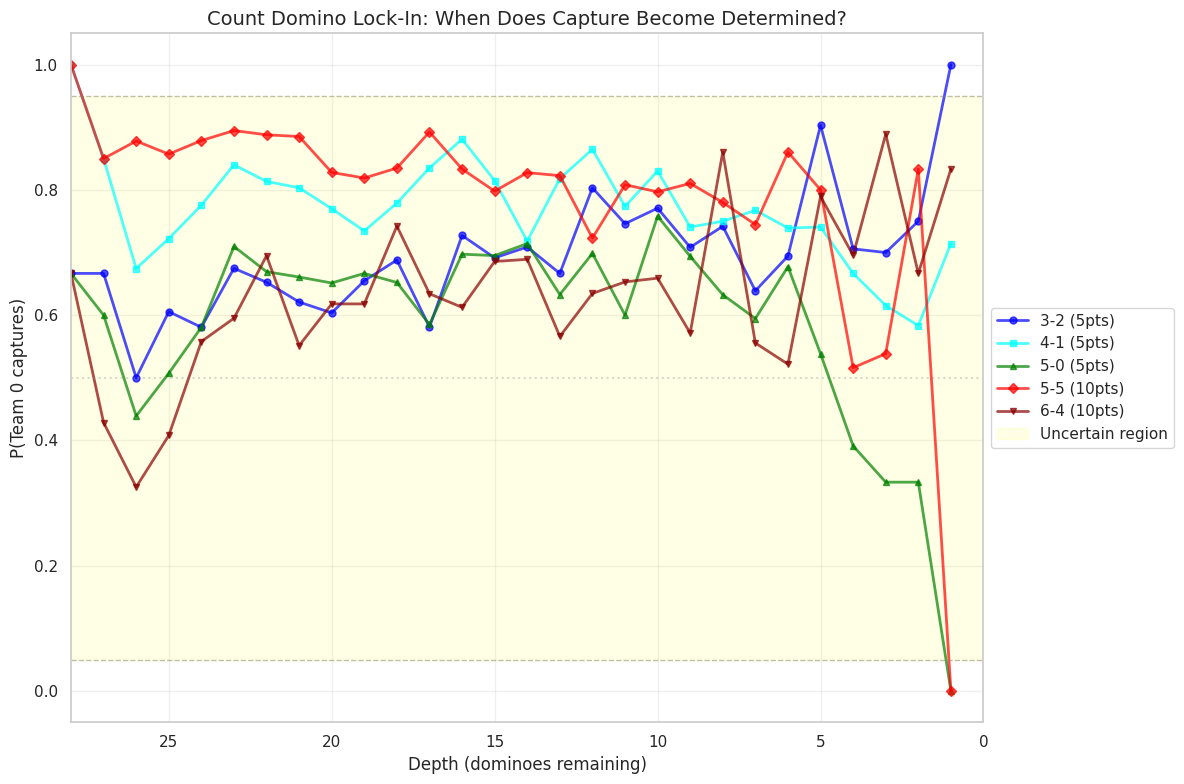

In [8]:
# Create combined plot showing all 5 counts
fig, ax = plt.subplots(figsize=(12, 8))

# Define styles for each count using actual domino IDs
styles = {}
for domino_id in features.COUNT_DOMINO_IDS:
    pips = schema.domino_pips(domino_id)
    points = tables.DOMINO_COUNT_POINTS[domino_id]
    color = 'red' if points == 10 else 'blue'
    styles[domino_id] = {
        'color': color,
        'marker': 'o',
        'label': f'{pips[0]}-{pips[1]} ({points}pts)'
    }

# Adjust colors for visual distinction
color_cycle = ['blue', 'cyan', 'green', 'red', 'darkred']
for i, domino_id in enumerate(sorted(features.COUNT_DOMINO_IDS)):
    styles[domino_id]['color'] = color_cycle[i]
    styles[domino_id]['marker'] = ['o', 's', '^', 'D', 'v'][i]

for domino_id in features.COUNT_DOMINO_IDS:
    if domino_id not in prob_curves or not prob_curves[domino_id]:
        continue
    depths_list = sorted(prob_curves[domino_id].keys(), reverse=True)
    probs = [prob_curves[domino_id][d][0] for d in depths_list]
    
    style = styles[domino_id]
    ax.plot(depths_list, probs, marker=style['marker'], color=style['color'], 
            label=style['label'], markersize=5, alpha=0.7, linewidth=2)

# Add threshold lines
ax.axhline(y=0.05, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(y=0.95, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.3)

# Add shaded "uncertain" region
ax.axhspan(0.05, 0.95, alpha=0.1, color='yellow', label='Uncertain region')

ax.set_xlabel('Depth (dominoes remaining)', fontsize=12)
ax.set_ylabel('P(Team 0 captures)', fontsize=12)
ax.set_title('Count Domino Lock-In: When Does Capture Become Determined?', fontsize=14)
ax.set_xlim(28, 0)
ax.set_ylim(-0.05, 1.05)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/08a_lock_in_combined.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Summary

In [9]:
# Summary statistics
summary = {
    'Shards analyzed': N_SHARDS,
    'Total observations': f"{len(per_seed_outcomes):,}",
    'Mean lock-in depth': f"{lock_in_df['lock_in_depth'].mean():.1f}",
    'Earliest lock-in': f"{lock_in_df['lock_in_depth'].min()}",
    'Latest uncertainty': f"{lock_in_df['max_uncertain_depth'].max()}",
}

print("\n" + "="*60)
print("08a SUMMARY: Count Lock-In Depth Analysis")
print("="*60)
for k, v in summary.items():
    print(f"{k}: {v}")
print("="*60)


08a SUMMARY: Count Lock-In Depth Analysis
Shards analyzed: 3
Total observations: 8,771
Mean lock-in depth: 2.4
Earliest lock-in: 2
Latest uncertainty: 27


In [10]:
# Save results
lock_in_df.to_csv('../../results/tables/08a_lock_in_stats.csv', index=False)
print("Results saved to:")
print("  - figures/08a_lock_in_curves.png")
print("  - figures/08a_lock_in_combined.png")
print("  - tables/08a_lock_in_stats.csv")

Results saved to:
  - figures/08a_lock_in_curves.png
  - figures/08a_lock_in_combined.png
  - tables/08a_lock_in_stats.csv
